Załączmy potrzebne importy

In [485]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn import  metrics

warnings.filterwarnings("ignore")

Wczytujemy dane z pliku

In [486]:
df = pd.read_csv('sample_data/train.csv')

Zobaczmy jak wyglądają dane

In [410]:
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


Opis danych

• Sex: płeć ("M" lub "F")

• Age: wiek pacjenta

• is_smoking: czy pacjent jest aktualnym palaczem ("YES" lub "NO")

• Cigs Per Day: ilość papierosów wypalanych dziennie

• BP Meds: czy pacjent przyjmował leki na nadciśnienie

• Prevalent Stroke: czy pacjent miał wcześniej udar

• Prevalent Hyp: czy pacjent miał nadciśnienie

• Diabetes: czy pacjent miał cukrzyce

• Tot Chol: poziom cholesterolu

• Sys BP: skurczowe ciśnienie krwi

• Dia BP: rozkurczowe ciśnienie krwii

• BMI: Body Mass Index

• Heart Rate: tętno

• Glucose: poziom glukozy

Target:

• 10 year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”)

## Przetwarzanie danych
• mapujemy płeć {"F" : 0, "M":1}

• mapujemy wartości w kolumnie is_smoking { "NO" : 0, "YES" : 1}

In [487]:
def sex_mapping(x):
    if x == "F":
        return 0
    else:
        return 1

def smoke_mapping(x):
    if x == "NO":
        return 0
    else:
        return 1

df.sex = df.sex.map(lambda x: sex_mapping(x))
df.is_smoking = df.is_smoking.map(lambda x: smoke_mapping(x))

Zobaczmy jak po mapowaniu wyglądają dane

In [412]:
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


Zajmijmy się teraz problemem ```missing data```

Na początek sprawdzmy, w których kolumnach brakuje wartości

In [413]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   int64  
 4   is_smoking       3390 non-null   int64  
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

Sprawdźmy teraz poszczególne kolumny

### Age

In [414]:
df.age.isnull().sum(axis=0)

0

### Education

In [415]:
df.education.isnull().sum(axis=0)

87

### Sex

In [416]:
df.sex.isnull().sum(axis=0)

0

### is_smoking

In [417]:
df.is_smoking.isnull().sum(axis=0)

0

### cigs_per_day

In [418]:
df.cigsPerDay.isnull().sum(axis=0)

22

### BPMeds

In [419]:
df.BPMeds.isnull().sum(axis=0)

44

### prevalent stroke

In [420]:
df.prevalentStroke.isnull().sum(axis=0)

0

### prevalentHyp

In [421]:
df.prevalentHyp.isnull().sum(axis=0)

0

### diabetes

In [422]:
df.diabetes.isnull().sum(axis=0)

0

### totChol

In [423]:
df.totChol.isnull().sum(axis=0)

38

### sysBP

In [424]:
df.sysBP.isnull().sum(axis=0)

0

### diaBP

In [425]:
df.diaBP.isnull().sum(axis=0)

0

### BMI

In [426]:
df.BMI.isnull().sum(axis=0)

14

### heartRate

In [427]:
df.heartRate.isnull().sum(axis=0)

1

### glucose

In [428]:
df.glucose.isnull().sum(axis=0)

304

Brakujące dane pojawiają się w kolumnach
* education
* cigs_per_day
* BPMeds
* totChol
* BMI
* heartRate
* glucose

Uzupełnijmy teraz brakujące dane

In [488]:
print(df.education.mean())
df['education'].fillna(value=int(df.education.mean()), inplace=True)

1.9709355131698456


In [489]:
print(df.cigsPerDay.mean())
df['cigsPerDay'].fillna(value= int(df.cigsPerDay.mean()), inplace=True)

9.069477434679335


In [490]:
print(df.BPMeds.mean())
df['BPMeds'].fillna(value=int(df.BPMeds.median()), inplace=True)

0.029886431560071727


In [491]:
print(df.heartRate.mean())
df['heartRate'].fillna(value=int(df.heartRate.mean()), inplace=True)

75.97727943346119


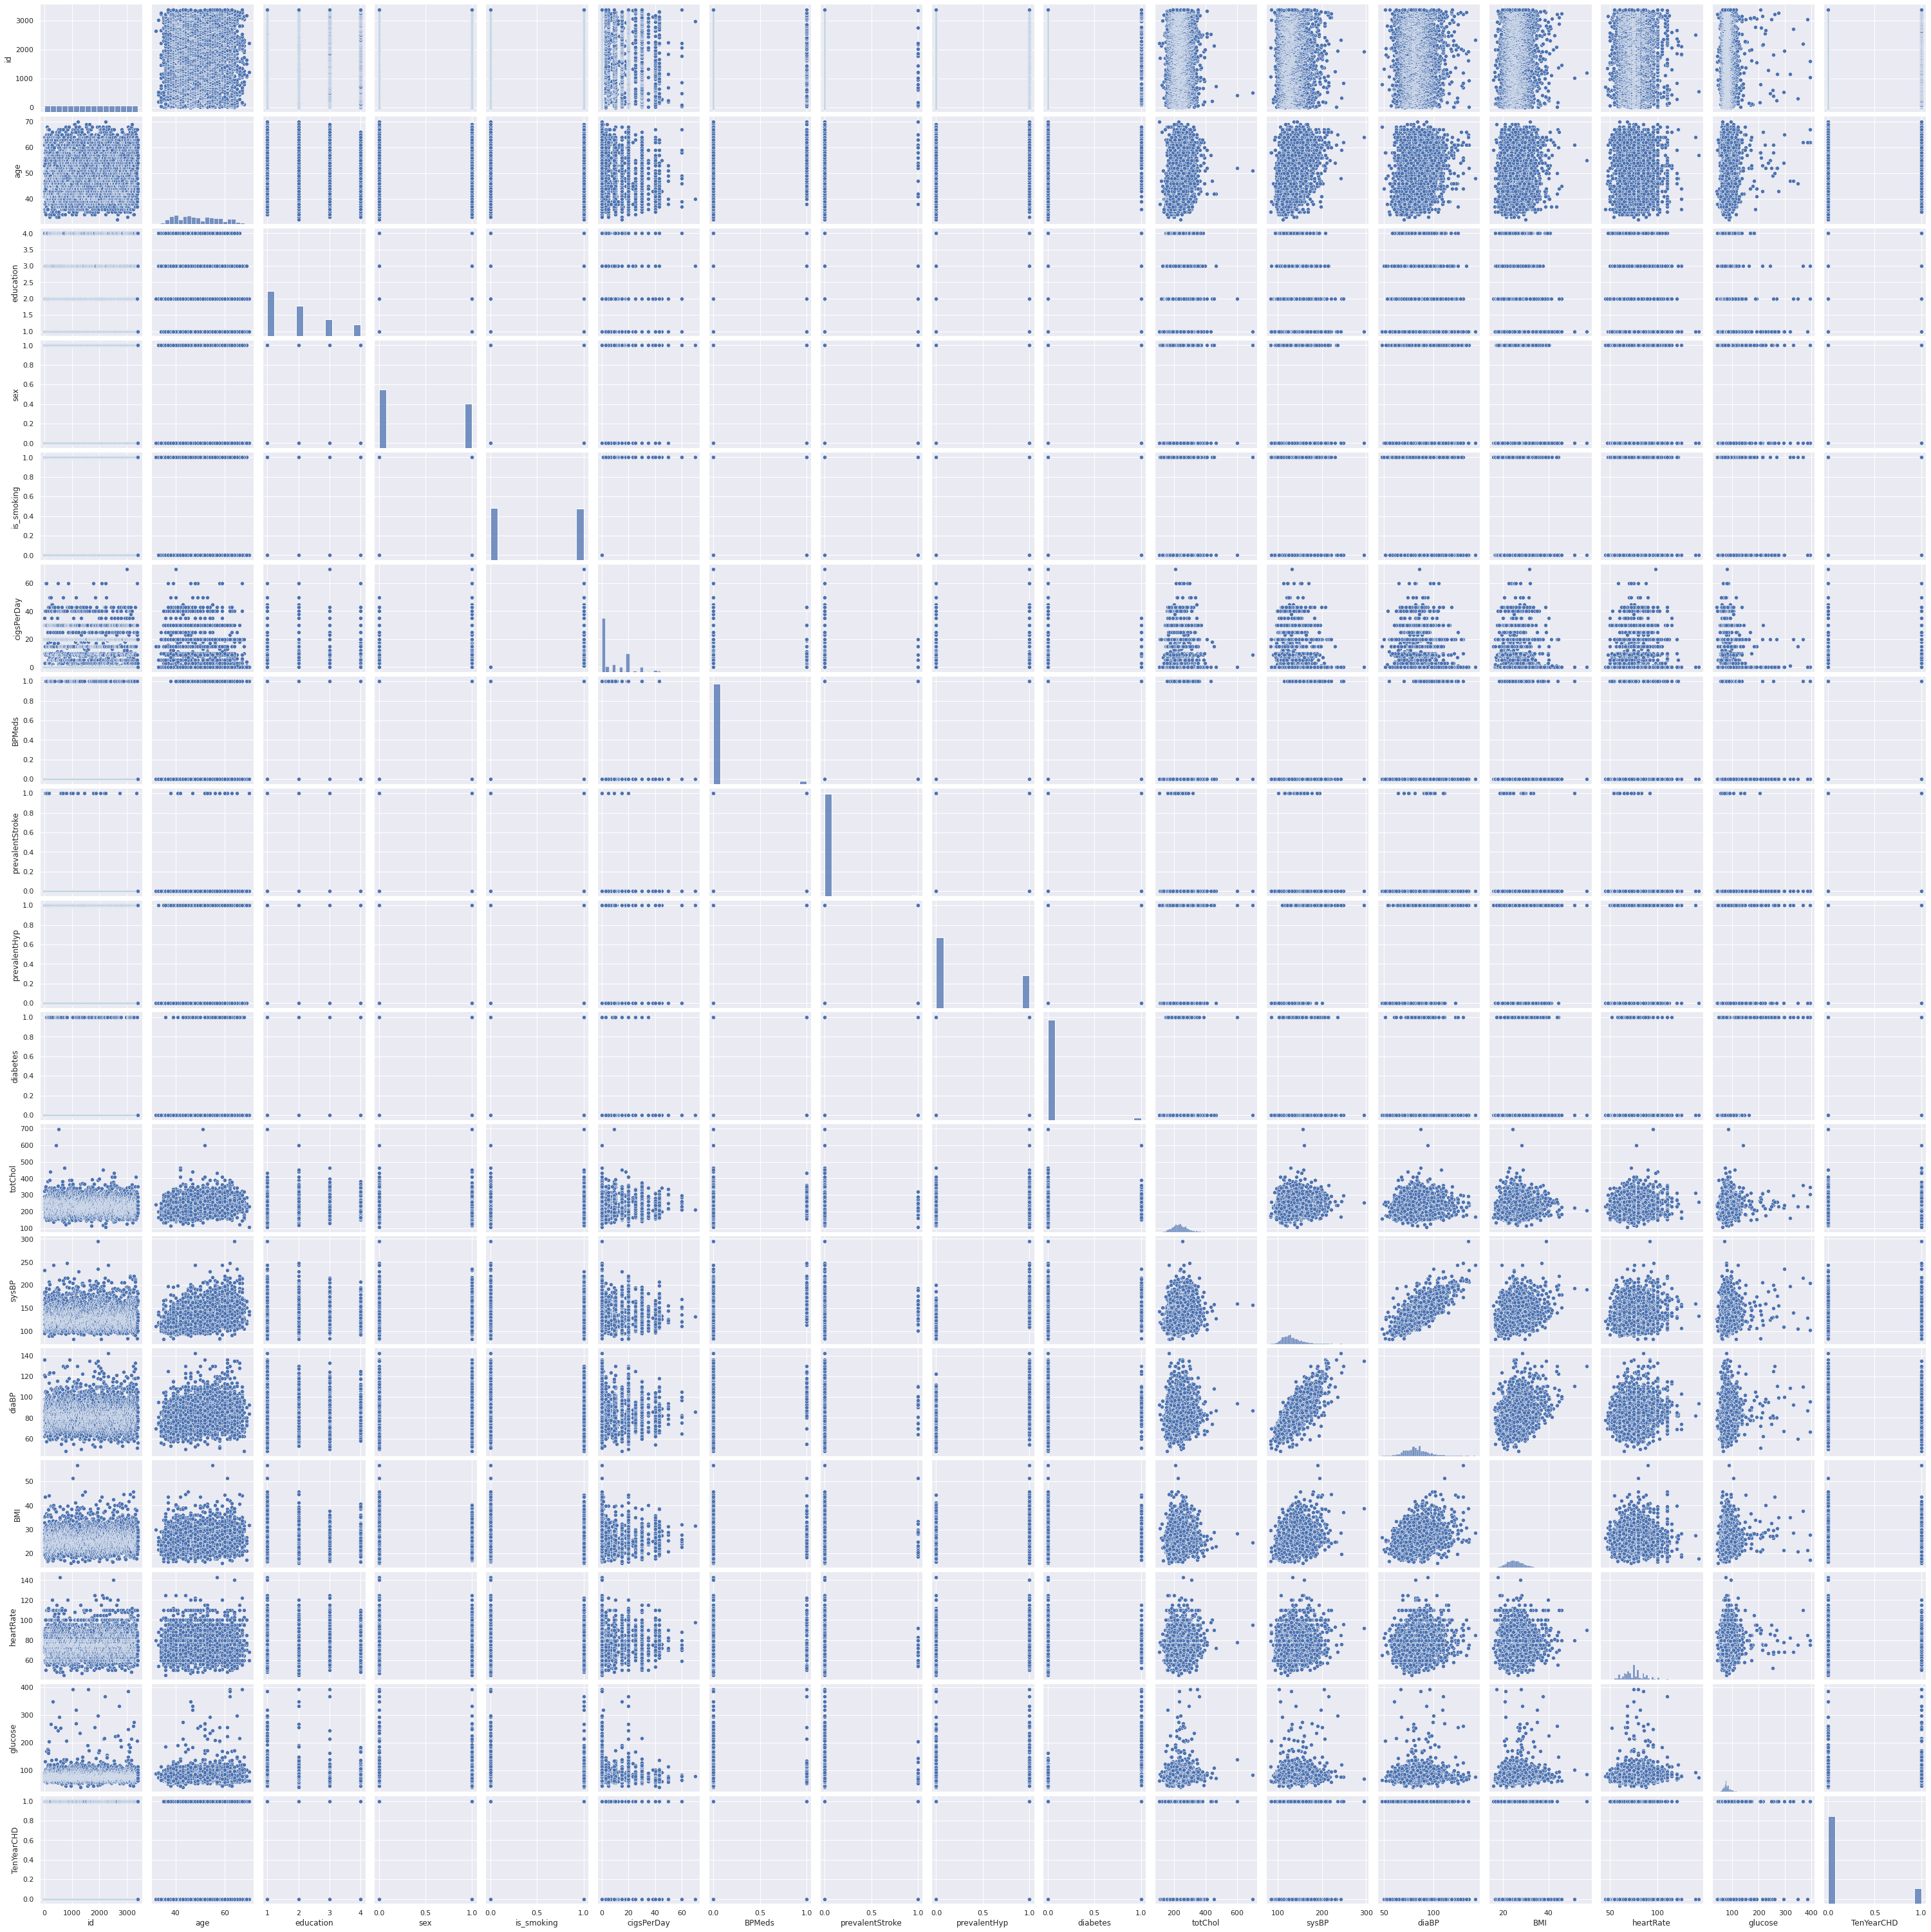

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
id,1.000000,0.016759,-0.027337,0.001004,-0.001511,-0.017199,0.007014,-0.038873,0.013236,0.003690,-0.019889,0.019676,0.000832,0.039849,0.024691,0.015517
age,0.016759,1.000000,-0.170614,-0.041882,-0.210997,-0.191955,0.122114,0.059038,0.308826,0.107875,0.274028,0.404845,0.221896,0.138176,-0.002636,0.116135
education,-0.027337,-0.170614,1.000000,0.025275,0.030193,0.014146,-0.019880,-0.031820,-0.081925,-0.051895,-0.021425,-0.132202,-0.060774,-0.136130,-0.039395,-0.039912
sex,0.001004,-0.041882,0.025275,1.000000,0.215485,0.331053,-0.043191,-0.011273,0.003072,0.008853,-0.070914,-0.037369,0.058840,0.087204,-0.118707,-0.007612
is_smoking,-0.001511,-0.210997,0.030193,0.215485,1.000000,0.769673,-0.037533,-0.043703,-0.119325,-0.053333,-0.047065,-0.145721,-0.124318,-0.173067,0.062152,-0.061555
cigsPerDay,-0.017199,-0.191955,0.014146,0.331053,0.769673,1.000000,-0.036654,-0.042053,-0.079086,-0.049006,-0.024603,-0.100545,-0.068550,-0.100857,0.066495,-0.068692
BPMeds,0.007014,0.122114,-0.019880,-0.043191,-0.037533,-0.036654,1.000000,0.116183,0.256892,0.070932,0.082365,0.260384,0.198780,0.087583,0.018107,0.064411
prevalentStroke,-0.038873,0.059038,-0.031820,-0.011273,-0.043703,-0.042053,0.116183,1.000000,0.071652,0.010115,-0.010832,0.057568,0.047235,0.018602,-0.019183,0.023607
prevalentHyp,0.013236,0.308826,-0.081925,0.003072,-0.119325,-0.079086,0.256892,0.071652,1.000000,0.082565,0.159680,0.699285,0.612897,0.300464,0.150731,0.086658
diabetes,0.003690,0.107875,-0.051895,0.008853,-0.053333,-0.049006,0.070932,0.010115,0.082565,1.000000,0.059080,0.124011,0.061165,0.089112,0.039746,0.620211


In [492]:
sns.pairplot(df)
plt.show()
corr = df.loc[:, df.columns != "TenYearCHD"].corr()
corr

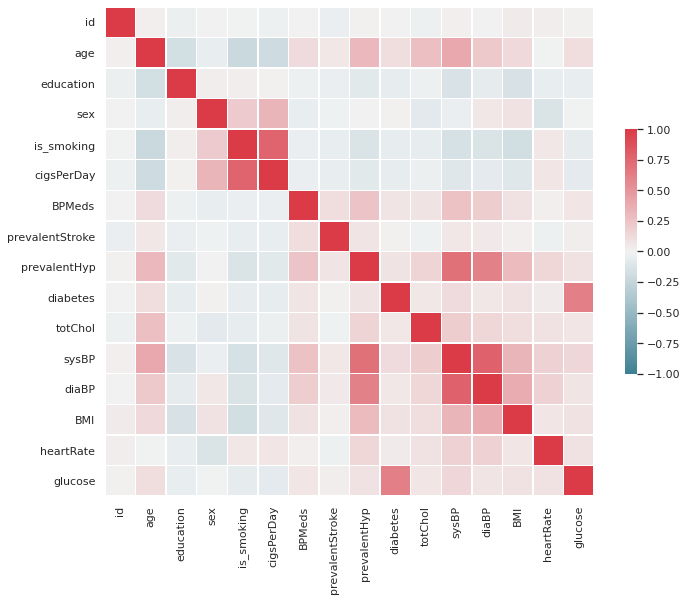

In [434]:
sns.set(style="darkgrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

In [435]:
bins = [30, 40, 50, 60, 100]
age_bins = (1, 2, 3, 4)
df['age-bin'] = pd.cut(df.age, bins, labels=age_bins).astype(int)

In [436]:
df.astype({'cigsPerDay': 'int64'}).dtypes

id                   int64
age                  int64
education          float64
sex                  int64
is_smoking           int64
cigsPerDay           int64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
age-bin              int64
dtype: object

In [437]:
df.cigsPerDay.isnull().sum(axis=0)
bins2 = [-1, 10,20,30,100]
cigs_bins = (1, 2, 3, 4)
df['cigs-bin'] = pd.cut(df.cigsPerDay, bins2, labels=cigs_bins).astype(int)



In [438]:
bins4 = [0, 100, 120, 140, 350]
sysBP_bins = (1, 2, 3, 4)
df['sysBP-bin'] = pd.cut(df.sysBP, bins4, labels=sysBP_bins).astype(float)

In [439]:
bins5 = [20,70,90,105,115, 200]
diaBP_bins = (1, 2, 3, 4,5)
df['diaBP-bin'] = pd.cut(df.diaBP, bins5, labels=diaBP_bins).astype(float)



In [440]:
bins7 = [40,60,80,90, 110, 120,220]
heartRate_bins = (1, 2, 3, 4,5,6)
df['heartRate-bin'] = pd.cut(df.heartRate, bins7, labels=heartRate_bins).astype(float)


In [441]:
df[['age-bin', 'BMI']].groupby(['age-bin']).mean()

,BMI
age-bin,
1,24.980583
2,25.473367
3,26.256673
4,26.716228


In [442]:
df.BMI.loc[df.BMI.isnull() & (df['age-bin'] == 1)] = 24.980583
df.BMI.loc[df.BMI.isnull() & (df['age-bin'] == 2)] = 25.473367
df.BMI.loc[df.BMI.isnull() & (df['age-bin'] == 3)] = 26.256673
df.BMI.loc[df.BMI.isnull() & (df['age-bin'] == 4)] = 26.716228

In [443]:
bins6 = [15,20, 23, 27, 30, 100]
BMI_bins = (1, 2, 3, 4,5)
df['BMI-bin'] = pd.cut(df.BMI, bins6, labels=BMI_bins).astype(float)

In [444]:
df[['BMI-bin', 'totChol']].groupby(['BMI-bin']).mean()

,totChol
BMI-bin,
1.0,220.382716
2.0,227.964286
3.0,239.018492
4.0,243.217836
5.0,241.490654


In [445]:
df.totChol.loc[df.totChol.isnull() & (df['BMI-bin'] == 1)] = 220.382716
df.totChol.loc[df.totChol.isnull() & (df['BMI-bin'] == 2)] = 227.964286
df.totChol.loc[df.totChol.isnull() & (df['BMI-bin'] == 3)] = 239.018492
df.totChol.loc[df.totChol.isnull() & (df['BMI-bin'] == 4)] = 243.217836
df.totChol.loc[df.totChol.isnull() & (df['BMI-bin'] == 5)] = 241.490654

In [446]:
bins3 = [0, 180, 230, 300, 350, 400, 800]
chol_bins = (1, 2, 3, 4,5,6)
df['chol-bin'] = pd.cut(df.totChol, bins3, labels=chol_bins).astype(float)

In [447]:
df[['diabetes', 'glucose']].groupby(['diabetes']).mean()

,glucose
diabetes,
0,79.571619
1,171.964286


In [448]:
df.glucose.loc[df.glucose.isnull() & (df['diabetes'] == 0)] = 79.571619
df.glucose.loc[df.glucose.isnull() & (df['diabetes'] == 1)] = 171.964286

In [449]:
bins8= [30,70, 100,500]
glucose_bins = (1, 2, 3)
df['glucose-bin'] = pd.cut(df.glucose, bins8, labels=glucose_bins).astype(float)

Na tym kończymy proces przetwarzania danych

Sprawdzmy teraz korelacje pomiędzy kolumnami a ryzykiem zachorowania

In [450]:
df[['education', 'TenYearCHD']].groupby(['education'], as_index=False).mean()

,education,TenYearCHD
0,1.0,0.182003
1,2.0,0.119192
2,3.0,0.127505
3,4.0,0.144772


In [451]:
df[['age-bin', 'TenYearCHD']].groupby(['age-bin'], as_index=False).mean()

,age-bin,TenYearCHD
0,1,0.049669
1,2,0.108340
2,3,0.198847
3,4,0.292208


In [452]:
df[['sex', 'TenYearCHD']].groupby(['sex'], as_index=False).mean()

,sex,TenYearCHD
0,0,0.124285
1,1,0.185412


In [453]:
df[['is_smoking', 'TenYearCHD']].groupby(['is_smoking'], as_index=False).mean()

,is_smoking,TenYearCHD
0,0,0.138579
1,1,0.163011


In [454]:
df[['cigs-bin', 'TenYearCHD']].groupby(['cigs-bin'], as_index=False).mean()

,cigs-bin,TenYearCHD
0,1,0.135074
1,2,0.166460
2,3,0.186667
3,4,0.251799


In [455]:
df[['BPMeds', 'TenYearCHD']].groupby(['BPMeds'], as_index=False).mean()

,BPMeds,TenYearCHD
0,0.0,0.145289
1,1.0,0.330000


In [456]:
df[['prevalentStroke', 'TenYearCHD']].groupby(['prevalentStroke'], as_index=False).mean()

,prevalentStroke,TenYearCHD
0,0,0.148753
1,1,0.454545


In [457]:
df[['prevalentHyp', 'TenYearCHD']].groupby(['prevalentHyp'], as_index=False).mean()

,prevalentHyp,TenYearCHD
0,0,0.110297
1,1,0.238541


In [458]:
df[['diabetes', 'TenYearCHD']].groupby(['diabetes'], as_index=False).mean()

,diabetes,TenYearCHD
0,0,0.144717
1,1,0.379310


In [459]:
df[['chol-bin', 'TenYearCHD']].groupby(['chol-bin'], as_index=False).mean()

,chol-bin,TenYearCHD
0,1.0,0.126582
1,2.0,0.121600
2,3.0,0.165810
3,4.0,0.222222
4,5.0,0.205882
5,6.0,0.444444


In [460]:
df[['sysBP-bin', 'TenYearCHD']].groupby(['sysBP-bin'], as_index=False).mean()

,sysBP-bin,TenYearCHD
0,1.0,0.093023
1,2.0,0.082840
2,3.0,0.132410
3,4.0,0.249243


In [461]:
df[['diaBP-bin', 'TenYearCHD']].groupby(['diaBP-bin'], as_index=False).mean()

,diaBP-bin,TenYearCHD
0,1.0,0.115063
1,2.0,0.128823
2,3.0,0.219835
3,4.0,0.235294
4,5.0,0.446809


In [462]:
df[['BMI-bin', 'TenYearCHD']].groupby(['BMI-bin'], as_index=False).mean()

,BMI-bin,TenYearCHD
0,1.0,0.175758
1,2.0,0.117037
2,3.0,0.134223
3,4.0,0.188133
4,5.0,0.188073


In [463]:
df[['heartRate-bin', 'TenYearCHD']].groupby(['heartRate-bin'], as_index=False).mean()

,heartRate-bin,TenYearCHD
0,1.0,0.127596
1,2.0,0.150854
2,3.0,0.147651
3,4.0,0.175758
4,5.0,0.333333
5,6.0,0.000000


In [464]:
df[['glucose-bin', 'TenYearCHD']].groupby(['glucose-bin'], as_index=False).mean()

,glucose-bin,TenYearCHD
0,1.0,0.135431
1,2.0,0.143690
2,3.0,0.259690


In [465]:
df = df.drop(labels=['age', 'BMI', 'glucose', 'heartRate', 'diaBP', 'sysBP', 'cigsPerDay', 'totChol'], axis=1)
X = df.loc[:, df.columns != "TenYearCHD"]
y = df['TenYearCHD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

print(y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

0       1
1       0
2       0
3       1
4       0
       ..
3385    0
3386    0
3387    1
3388    0
3389    0
Name: TenYearCHD, Length: 3390, dtype: int64
(3051, 16) (3051,)
(339, 16) (339,)


,id,education,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age-bin,cigs-bin,sysBP-bin,diaBP-bin,heartRate-bin,BMI-bin,chol-bin,glucose-bin
1577,1577,2.0,0,0,0.0,0,0,0,1,1,2.0,2.0,4.0,3.0,3.0,2.0
156,156,2.0,0,1,0.0,0,0,0,1,2,3.0,2.0,2.0,1.0,2.0,2.0
195,195,2.0,1,1,0.0,0,0,0,1,4,2.0,2.0,2.0,4.0,3.0,2.0
2180,2180,3.0,0,0,0.0,0,0,0,1,1,1.0,1.0,2.0,2.0,2.0,1.0
124,124,1.0,0,0,0.0,0,0,0,2,1,3.0,2.0,2.0,3.0,2.0,2.0


In [466]:
y_train.head()

1577    0
156     1
195     0
2180    0
124     0
Name: TenYearCHD, dtype: int64

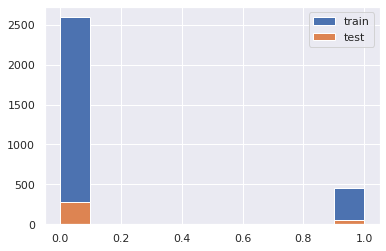

In [467]:
plt.hist(y_train, label="train")
plt.hist(y_test, label="test")
plt.legend()
plt.show()

In [468]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [469]:
pipeline1 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(probability=True))])

param_grid_1 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__gamma': [0.01, 0.1, 1],
            'classifier__C': [0.01, 0.1, 1]
}

grid_1 = GridSearchCV(pipeline1, param_grid_1, cv=kfold, return_train_score=True)
grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 1,
 'classifier__gamma': 0.1,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [470]:
pipeline_2 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel="poly", probability=True))])

param_grid_2 = {'preprocessing': [StandardScaler(), None],
              'classifier__C': [0.01, 0.1, 1],
              'classifier__coef0': [0.01, 0.1, 1],
             'classifier__degree': [1, 2, 3, 4]}
grid_2 = GridSearchCV(pipeline_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 0.01,
 'classifier__coef0': 1,
 'classifier__degree': 3,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [471]:
pipeline_3 = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel="linear", probability=True))])

param_grid_3 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.01, 0.1, 1]
}
grid_3 = GridSearchCV(pipeline_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__C': 0.01, 'preprocessing': None}

In [472]:
pipeline_4 = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(n_jobs=-1))])

param_grid_4 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [ 0.01, 0.1, 1, 10]
}

grid_4 = GridSearchCV(pipeline_4, param_grid_4, cv=kfold, return_train_score=True)
grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__C': 0.1,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [473]:
pipeline_5 = Pipeline([('preprocessing', StandardScaler()), ('classifier', LinearSVC(C=1))])

param_grid_5 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_5 = GridSearchCV(pipeline_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
grid_5.best_params_

{'classifier__C': 0.001,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [474]:
pipeline_6 = Pipeline([('preprocessing', StandardScaler()), ('classifier', KNeighborsClassifier(n_jobs=-1))])

param_grid_6 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__p': [1, 10, 100, 1000, 10000]
}

grid_6 = GridSearchCV(pipeline_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__p': 1000,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [475]:
pipeline_7 = Pipeline([('preprocessing', StandardScaler()), ('classifier', DecisionTreeClassifier())])

param_grid_7 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__max_depth': [1, 5, 10, 20],
            'classifier__max_leaf_nodes': [None, 5, 10, 20, 50, 100],
}

grid_7 = GridSearchCV(pipeline_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
grid_7.best_params_

{'classifier__max_depth': 1,
 'classifier__max_leaf_nodes': None,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [476]:
pipeline_8 = Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier(n_jobs=-1))])

param_grid_8 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators' : [1, 3, 5, 10, 50],
            'classifier__max_leaf_nodes' : [2, 4, 8, 16, 32, 64],
}

grid_8 = GridSearchCV(pipeline_8, param_grid_8, cv=kfold, return_train_score=True)

grid_8.fit(X_train, y_train)
grid_8.best_params_

{'classifier__max_leaf_nodes': 32,
 'classifier__n_estimators': 50,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [477]:
pipeline_9 = Pipeline([('preprocessing', StandardScaler()), ('classifier', BaggingClassifier())])

param_grid_9 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__max_samples' : [0.05, 0.1, 0.2, 0.5, 0.7, 1]
}

grid_9 = GridSearchCV(pipeline_9, param_grid_9, cv=kfold, return_train_score=True)

grid_9.fit(X_train, y_train)
grid_9.best_params_

{'classifier__max_samples': 1,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [478]:
pipeline_10 = Pipeline([('preprocessing', StandardScaler()), ('classifier', ExtraTreesClassifier(n_jobs=-1))])

param_grid_10 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators' : [5, 10, 50, 100],
            'classifier__max_leaf_nodes' : [2, 4, 8, 16, 32, 64],
}

grid_10 = GridSearchCV(pipeline_10, param_grid_10, cv=kfold, return_train_score=True)

grid_10.fit(X_train, y_train)
grid_10.best_params_

{'classifier__max_leaf_nodes': 64,
 'classifier__n_estimators': 10,
 'preprocessing': None}

In [479]:
pipeline_11 = Pipeline([('preprocessing', StandardScaler()), ('classifier', AdaBoostClassifier())])

param_grid_11 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators' : [10, 50, 100, 500, 600, 700],
            'classifier__learning_rate' : [ 0.01, 0.1, 0.5, 0.7, 1],
}

grid_11 = GridSearchCV(pipeline_11, param_grid_11, cv=kfold, return_train_score=True)

grid_11.fit(X_train, y_train)
grid_11.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 700,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [480]:
pipeline_12 = Pipeline([('preprocessing', StandardScaler()), ('classifier', GradientBoostingClassifier())])

param_grid_12 = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators' : [5, 10, 50, 100, 500],
            'classifier__learning_rate' : [0.001, 0.01, 0.1, 0.5, 0.7, 1],
}

grid_12 = GridSearchCV(pipeline_12, param_grid_12, cv=kfold, return_train_score=True)

grid_12.fit(X_train, y_train)
grid_12.best_params_

{'classifier__learning_rate': 0.001,
 'classifier__n_estimators': 5,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [481]:
models = []
models.append(('SVM rbf', grid_1.best_estimator_))
models.append(('SVM poly', grid_2.best_estimator_))
models.append(('SVM linear', grid_3.best_estimator_))
models.append(('Logistic regression', grid_4.best_estimator_))
models.append(('LinearSVC', grid_5.best_estimator_))
models.append(('KNeighborsClassifier', grid_6.best_estimator_))
models.append(('DecisionTreeClassifier', grid_7.best_estimator_))
models.append(('RandomForestClassifier', grid_8.best_estimator_))
models.append(('BaggingClassifier', grid_9.best_estimator_))
models.append(('ExtraTreesClassifier', grid_10.best_estimator_))
models.append(('AdaBoostClassifier', grid_11.best_estimator_))
models.append(('GradientBoostingClassifier', grid_12.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'LinearSVC'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))
    else:
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

In [482]:
d = {
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
result = pd.DataFrame(data=d)
result.insert(loc=0, column='Method', value=['SVM rbf', 'SVM poly', 'SVM linear', 'Logistic regression', 'LinearSVC', 'KNeighborsClassifier', 'DecisionTreeClassifier',
                                         'RandomForestClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'AdaBoostClassifier','GradientBoostingClassifier'])
result

,Method,accuracy_score,roc_auc_score
0,SVM rbf,0.831858,0.622471
1,SVM poly,0.834808,0.577017
2,SVM linear,0.837758,0.712036
3,Logistic regression,0.837758,0.726056
4,LinearSVC,0.837758,0.729001
5,KNeighborsClassifier,0.825959,0.613572
6,DecisionTreeClassifier,0.837758,0.603393
7,RandomForestClassifier,0.837758,0.702465
8,BaggingClassifier,0.837758,0.500000
9,ExtraTreesClassifier,0.831858,0.689597


In [483]:
model = Sequential()

model.add(
    Dense(32, kernel_initializer='uniform', activation='relu', input_dim=16))
model.add(Dense(20, kernel_initializer='uniform', activation='relu'))
model.add(Dense(6, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=32, epochs=350)

Epoch 1/350
96/96 [==============================] - 1s 2ms/step - loss: 0.5448 - accuracy: 0.8470
Epoch 2/350
96/96 [==============================] - 0s 2ms/step - loss: 0.4845 - accuracy: 0.8428
Epoch 3/350
96/96 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.8409
Epoch 4/350
96/96 [==============================] - 0s 2ms/step - loss: 0.4575 - accuracy: 0.8608
Epoch 5/350
96/96 [==============================] - 0s 2ms/step - loss: 0.4407 - accuracy: 0.8624
Epoch 6/350
96/96 [==============================] - 0s 1ms/step - loss: 0.4515 - accuracy: 0.8597
Epoch 7/350
96/96 [==============================] - 0s 2ms/step - loss: 0.4578 - accuracy: 0.8419
Epoch 8/350
96/96 [==============================] - 0s 2ms/step - loss: 0.4457 - accuracy: 0.8472
Epoch 9/350
96/96 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.8515
Epoch 10/350
96/96 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.8522
Epoch 11/

In [484]:
print(metrics.accuracy_score(y_true=y_test, y_pred=model.predict_classes(X_test)))

0.8348082595870207


Podsumowanie

Pomimo niekompletności danych, w niektórych kolumnach (zwłasza w kolumnie glucose, która była istotna ponieważ istniała korelacja pomiędzy chorobą cukrzycy a ryzykiem wystąpienia choroby wieńcowej) udało się osiągnąć zadowalające wyniki predykcji. Brakujące dane zostały uzupełnione na podstawie pozostałych danych.
